<a href="https://colab.research.google.com/github/bobglithero/shared_projects/blob/main/ai_for_product_marketing/AI_Assistants_for_PMMs_Audio_Transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Assistants for Product Marketing: Audio Transcription and Extraction

By [Bob Glithero](https://www.**linkedin**.com/in/glithero)

January 13, 2025

In my work I need to transcribe a great deal of video and audio, and I've not been satisfied with either the pricing or the conversation limits of the commercial transcription services I've used.

So I created my own script for this. This notebook draws from pieces of my own data prep workflow:  preparing the audio from a podcast to send to a transcription endpoint, getting the transcription, and extracting keywords and other content for cataloging and downstream use (in a RAG system for example).

With some additions, this code can also transcribe audio from video when a caption track isn't available. I was able to process just over **10 hours** of video in **22 minutes** at a cost of **$3.30** using OpenAI Whisper for transcription and Google Gemini Pro for extracting labels, snippets, and summaries.  An events team could process the video from a two-day conference in about half an hour for the price of a latte.

Multi-modal LLMs can transcribe from video directly, but output limits can restrict the length of the video you can use without chunking it into smaller files.  Also, it takes about ten times as many input tokens to upload a video instead of the audio track alone. Many model providers just extract the audio track in the background anyway, so I did it myself in a few minutes and cut my token usage by **~90%**.

## Prerequisites

Each code cell generates output, which I've already run.  You can simply review the notebook as-is without doing anything else, or you follow the instructions below to re-run the notebook.

The audio conversion code in Part 1 doesn't require any credentials to run. But if you want to re-run the transcriptions and extractions in Part 2, you'll need a Gemini API key.  To generate an API key, [go to the Google AI Studio website](https://aistudio.google.com), log in with your Google account, and navigate to the API settings page where you can click "Get API key" or "Create API key" to generate a new key; ensure you keep this key secure as it grants access to your Google Cloud project and Gemini models.

Key steps:

* Login with Google account: Sign in using your Google credentials.
* Find API key option: Look for "Get API key" or a similar button, usually located in the top left corner.
* Create new key: Click the button to generate a new API key. You'll copy this key to your notebook.

Once you've created the API key, you'll need to add it to the notebook (open the key icon in the left panel).
* For name, use GEMINI_API_KEY
* For value, copy the key from AI Studio (that long list of characters).
* Click the "Notebook Access" slider so it's active.

This document gives you step-by-step instructions, spefically see "Colab Secrets":
https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb#scrollTo=dEoigYI9Jw_K

Important: name your key GEMINI_API_KEY, not GOOGLE_API_KEY, or the notebook won't work.

This notebook uses the [Google AI Python SDK for the Gemini API](https://github.com/google-gemini/generative-ai-python) (the Developer API).

To run a cell, just click Ctrl-Enter, or the 'playback' icon on the left side of the cell.

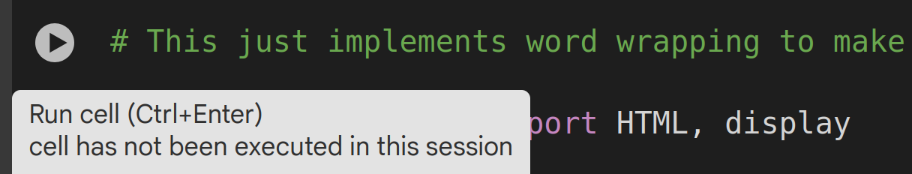

## Part 1:  Audio Encoding

In this section, we'll walk through:

1. Choosing a model
2. Installing software and libraries
3. Creating an audio encoding function
4. Shrinking the audio to an efficient size

We'll be working with an AI-generated podcast I created using [Google NotebookLM](https://notebooklm.google.com/). The podcast file size is 53 MB. Some transcription endpoints restrict the size of the file you can upload. Google Gemini has a file size limit of 100 MB, so compressing the audio is not absolutely necessary here (although GitHub is complaining about the size of the file). However, we might want to use it for other AI services with different upload limits.  So it's a good idea to know how to do this, and it takes only seconds. We'll end up with an output file around 2.4 MB, which is about a 95% reduction in size.

### Choosing a Model

There are a lot of commercial choices for transcribing audio to text, although some are just wrappers to endpoints like the ones below.  Let's look at three transcription endpoints to see what they offer (all prices current as of publication):

- The **OpenAI Whisper** API endpoint costs **\$.006** per minute of transcription, but it has a **25 MB** size limit for uploading a single audio file. This is enough for at least a couple of hours of compressed audio.  Whisper does a good job of transcription, but it doesn't support diarization (speaker identification).  Since our example audio is a podcast, this would be a nice feature to have.
- The **Google Speech-to-Text** API endpoint costs **\$.016** per minute.  For audio uploaded from your local drive, there's also a **10 MB** file size limit.  However, there are no size limits if the file is stored in Google Cloud Storage. Google Speech-to-Text also offers diarization.
- **Google Gemini** is a family of multi-modal LLMs that can transcribe audio with diarization. Gemini currently has a free tier, but with limits on the number of input/output tokens and the number of requests per minute. The input limits (**1M tokens** for Gemini Flash, **2M tokens** for Pro) are enough for hours of compressed audio, but the output limit is **8,192 tokens** (a page of single-spaced text is about 1,000 tokens).  In my experience that's good for up to 45 minutes of audio, plus or minus.
- Google Speech-to-Text does not accept prompts, Whisper accepts simple prompts (e.g., remove filler words like 'uhh'), while Gemini accepts more sophisticated prompts to customize or structure the output.

Most of the time I work with Whisper, but I'm picking Gemini for this demo. 'Free' is a price I like, our file size and number of requests will easily fit within the limits, and it supports speaker diarization.

### Preparing the Environment

First we need to prepare our environment for audio conversion. We'll be using the [ffmpeg](https://ffmpeg.org/) library to do the conversion.  ffmpeg is like a Swiss army knife for working with video and audio. In the next cells, we'll take care of some housekeeping:

- Make some changes to how the cell output is formatted
- Install the Gemini API SDK
- Install the ffmpeg library for media transcoding
- Import all of the libraries we'll need
- Load the Gemini API key
- Download the sample data

In [1]:
# This just implements word wrapping to make the output cells easier to read.

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
!pip install -U -q "google-generativeai>=0.7.2" # Install the Developer SDK

In [3]:
# Get the libraries we'll need

import google.generativeai as genai  # Gemini API SDK
import os # for working with directories and files
import urllib.request # we'll use this to download sample data
from google.colab import userdata # for loading the API key you created.
import subprocess # runs operating system commands (ffmpeg)
import json # working with JSON data objects
import re # working with regular expressions

In [4]:
!apt-get install -y ffmpeg  # ffmpeg should already be installed, but let's make sure.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
GEMINI_API_KEY=userdata.get('GEMINI_API_KEY') # Load the API key.
genai.configure(api_key=GEMINI_API_KEY)

In [15]:
# Download the data from GitHub. This is overkill for one file, but it's handy if you have a directory full of files.

github_base_url = "https://raw.githubusercontent.com/bobglithero/shared_projects/main/ai_for_product_marketing/"
filenames = ["podcast.wav"] # List of filenames to get, separated by commmas

for filename in filenames:
    data_url = github_base_url + filename
    data_path = os.path.join("/content", filename) # '/content' is the home directory for Colab
    try:
        urllib.request.urlretrieve(data_url, data_path)
        print(f"Downloaded {filename} to {data_path}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

#'test.wav' should be visible in your directory (click the folder icon to the left)

Downloaded podcast.wav to /content/podcast.wav


### Define the Audio Encoding Function

The next cell defines our core conversion function that transforms WAV files to AAC, a format that stores audio information efficiently:

1. **Purpose**:
   - Takes a WAV file and converts it to AAC format using ffmpeg
   - Uses a low bitrate (16k) suitable for speech audio

2. **Parameters**:
   - `input_file`: the source WAV file
   - `output_file`: the converted M4A file

3. **Return Value**:
   - `True` if conversion succeeds
   - `False` if conversion fails

This function won't output anything to your screen - it's invoked when we want to perform the encoding.

In [17]:
input_file = 'podcast.wav'
output_file = 'podcast.m4a'

def encode_audio(input_file, output_file):
    """Encodes an audio file to AAC format using ffmpeg."""
    cmd = [
            "ffmpeg",
            "-y",  # Force target file overwrite without prompting
            "-i", input_file, # the file we want to encode
            "-c:a", "aac", # sets codec
            "-b:a", "16k", # sets bitrate
            "-ac", "1", # mono audio to save more space
            "-loglevel", "error",
            "-stats",
            output_file
        ]

    print(f"Converting {input_file} to AAC format...")
    import subprocess
    import os
    result = subprocess.run(cmd, capture_output=True, text=True)
# subprocess runs operating system commands from python (ffmpeg)

    if result.returncode == 0 and os.path.exists(output_file):
      print(f"Successfully encoded to {output_file}")
      return True
    else:
      print(f"Conversion failed: {result.stderr}")
      return False

# This cell displays nothing to your screen. We call the function in the next cell.

### Process Files

This cell invokes the 'encode_audio' function we just defined to perform the actual file conversion:

1. **Operation**:
   - Checks if podcast.wav exists in the input directory
   - Converts the file if found
   - Displays a summary of the results

2. **Expected Input**:
   - Looks for `podcast.wav`

3. **Output**:
   - Creates `podcast.m4a` if successful
   - Displays a summary showing input and output filenames

If the conversion fails, error messages will help identify the problem.

In [18]:
if input_file:
    success = encode_audio(input_file, output_file)

    result = "Success" if success else "Failed"
    summary = f"""
    Conversion Results:
    ------------------
    Input file: {input_file}
    Output file: {output_file}
    """
    print(f"{summary}")

else:
    print("Error: test.wav not found")

Converting podcast.wav to AAC format...
Successfully encoded to podcast.m4a

    Conversion Results:
    ------------------
    Input file: podcast.wav
    Output file: podcast.m4a
    


## Part 2:  Audio Transcription and Extraction with Google Gemini

In this section we'll take the next step after encoding our audio file. &nbsp;We'll walk through how to use Google Gemini to transcribe audio files with speaker diarization and extract structured information from the transcriptions. &nbsp;Part 2 covers:
1. Uploading the input file and selecting a model
2. Transcribing audio with speaker identification (takes a few minutes).
3. Processing transcriptions to extract structured data in JSON format

In [19]:
# setup

audio_file_name = "podcast.m4a"
audio_file = genai.upload_file(path=audio_file_name) # upload the file
model_name = "models/gemini-1.5-pro" # "models/'model name'" to change the model you're using

In [20]:
prompt = '''Transcribe the audio. Remove filler words (umm, huh, uhh, mmm, and repeat words). /
        Identify and label each speaker as speaker 1, speaker 2, and so on.'''

model = genai.GenerativeModel(model_name)

transcription = model.generate_content([prompt, audio_file]) # Gets the transcription. This could take a few minutes.

print(f"Finished transcription of {audio_file_name}.")

Finished transcription of podcast.m4a.


In [21]:
print(f"Transcription:\n\n{transcription.text[:1500]}") # Prints the first 1,500 characters. Remove [:1500] to see the whole thing.

Transcription:

Speaker 1: Okay, so we’re diving into AI and SEO today.
Speaker 2: Yeah. Looks like you’re trying to figure out if your website is ready for this whole AI search thing. You’ve got a ton of research articles and even some of your personal notes in this stack.
Speaker 1: Oh, wow.
Speaker 2: It’s a pretty big topic.
Speaker 1: Yeah, it is.
Speaker 2: Don’t worry, we’ll help you break it all down.
Speaker 1: It’s interesting, it’s not just about new AI search engines like ChatGPT.
Speaker 2: Right.
Speaker 1: Even Google is incorporating AI into practically every aspect of search.
Speaker 2: Yeah. Some of these stats are pretty crazy.
Speaker 1: Oh, yeah. Like one study found that when Google’s AI summaries show up, the top organic search result can see a 70% drop in traffic.
Speaker 2: Wow! 70%?
Speaker 1: That’s huge.
Speaker 2: Yeah. It really is, and overall, we’re seeing a decline in organic traffic across the board. It’s a lot of what we call zero-click searches.
Spea

### Analyzing Token Usage

'Transcription' is an object that has methods like **.text**, which gives us the transcribed text, and **.usage_metadata** bold text which shows us the input and output tokens used.

In [22]:
transcription.usage_metadata # Gemini's paid tiers increase pricing after 128K tokens.

prompt_token_count: 35607
candidates_token_count: 5740
total_token_count: 41347

### Structured Information Extraction

Next, we'll prompt Gemini to extract some information from the transcription and to create labels and other items that we can use in a variety of ways.  The Developer API gives us a method to get structured outputs, but I also want to specify some length guidelines for each type of content.  The API doesn't seem to provide a straightforward way to do that, so we'll create a system instruction instead (this works better with Pro, Flash tends to return everything no matter what's requested).

The system instruction will process the transcription and extract structured information as a JSON object, which is a standard format for sharing data among applications. We'll ask for one or more of these:

- summary (300 words)
- description (100 words)
- snippet (50 words)
- labels (keywords and topics)
- all of the above


In [23]:
system_instruction = '''You will be asked to extract elements from the given text. /
                        If you're asked to extract a summary or a briefing, return a JSON object with about 300 words of text. Use "summary" as the key /
                        and your text response as the value.
                        If you're asked to extract a description or an abstract, return a JSON object with 100 words of text. Use "description" as the key. /
                        If you're asked to extract a snippet, tweet, or a tagline, return a JSON object with 50 words of text. Use "snippet" as the key. /
                        If you're asked to extract keywords or topics, then return a JSON object containing only those items closely related to the text. /
                        Use "labels" as the key for a nested JSON object with "keywords" and "topics" as keys./
                        If the user asks for 'all' or 'everything', then return a nested JSON object with all of the above: summary, abstract, snippet, and labels.'''

In [24]:
request = input("What do you want to do (e.g., ask for summary/description/labels/everything)? ").strip()

prompt = f"{request}. Use this text:{transcription.text}"

model = genai.GenerativeModel(model_name, system_instruction=system_instruction)

response = model.generate_content(prompt)

print(response.text)

What do you want to do (e.g., ask for summary/description/labels/everything)? I would like everything.
```json
{
  "summary": "This conversation explores the impact of AI on SEO and search. The speakers discuss how AI-powered features like Google's AI summaries are changing user behavior, leading to a decline in organic traffic and an increase in zero-click searches. They highlight the growing importance of AI chatbots like ChatGPT, which further challenge traditional SEO strategies. The discussion emphasizes the need for website owners and marketers to adapt to this evolving landscape by optimizing content for natural language queries, leveraging structured data, and focusing on brand building.  They delve into the significance of E-E-A-T (experience, expertise, authoritativeness, and trustworthiness) in AI-driven search and content evaluation.  Practical strategies are offered, including creating a centralized content repository, focusing on high-quality, unique content, and diversif

### Transforming the Results

What the model returns is markdown. &nbsp;We can't work with this directly. &nbsp;Let's convert it into a form we can work with more easily. &nbsp;We'll use a [regular expression](https://realpython.com/regex-python/) to extract a JSON object.

In [25]:
# Regular expression to match JSON content within markdown code blocks
pattern = r"```json\s*(.*?)\s*```"

# Using re.DOTALL flag to make '.' match newlines as well
match = re.search(pattern, response.text, re.DOTALL)

# Extract and parse the JSON string
json_str = match.group(1)
output = json.loads(json_str)

output

{'summary': "This conversation explores the impact of AI on SEO and search. The speakers discuss how AI-powered features like Google's AI summaries are changing user behavior, leading to a decline in organic traffic and an increase in zero-click searches. They highlight the growing importance of AI chatbots like ChatGPT, which further challenge traditional SEO strategies. The discussion emphasizes the need for website owners and marketers to adapt to this evolving landscape by optimizing content for natural language queries, leveraging structured data, and focusing on brand building.  They delve into the significance of E-E-A-T (experience, expertise, authoritativeness, and trustworthiness) in AI-driven search and content evaluation.  Practical strategies are offered, including creating a centralized content repository, focusing on high-quality, unique content, and diversifying channels beyond traditional search.  The conversation also touches upon the role of structured data as the la

### Retrieving Individual Elements

Now that we've transformed the output, we can easily access specific elements like topics and descriptions by providing the keys.

In [26]:
print(", ".join(x for x in output["labels"]["topics"])) # Extracts the items from the list of topics

Artificial Intelligence, Search Engine Optimization, Digital Marketing, Content Marketing, Search Engine Marketing, AI in Search, Future of SEO


In [27]:
print(output["description"])

This discussion centers on the transformative impact of AI on SEO and the search landscape. The speakers analyze how AI-driven features like Google's AI summaries and chatbots like ChatGPT are reshaping user search behavior and the implications for website traffic.  Key takeaways include the need for content optimization for natural language, leveraging structured data, and prioritizing brand building. The importance of E-E-A-T and adapting SEO strategies to the evolving digital environment are underscored.


## Summary

We've just walked through a sample workflow where we shrank a podcast for transcription, transcribed the audio, and extracted additional information we can use for labeling and cataloging the data. Feel free to experiment with the code and see what else you could do, like asking the model to draft a blog from the transcription.

The code in this notebook is ok for one-off usage. For something that runs without a notebook, take a look at the accompanying **audio_encoder.py** script.  It can run standalone or as part of a media processing pipeline. The script handles command-line arguments and user inputs, performs validity checks to gracefully deal with a variety of failure modes like missing directories or files, and it provides event logging for debugging.

I hope you found this interesting!  Feel free to [connect with me on LinkedIn](https://www.linkedin.com/in/glithero) and leave me your thoughts or questions.